## Imports and Configurations

In [1]:
import os.path
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
%matplotlib inline

In [2]:
# Configurations here
data_folder = './data/udacity_data'
training_file = 'train_227_227.p'
training_image_size = (227, 227)

flags = {
    'create_training_pickle': False
}

## Load and Preprocess Data

In [3]:
df = pd.read_csv(os.path.join(data_folder, 'driving_log.csv'))
df.tail()

,center,left,right,steering,throttle,brake,speed
8031,IMG/center_2016_12_01_13_46_38_745.jpg,IMG/left_2016_12_01_13_46_38_745.jpg,IMG/right_2016_12_01_13_46_38_745.jpg,0.0,0.0,0.0,1.402436
8032,IMG/center_2016_12_01_13_46_38_802.jpg,IMG/left_2016_12_01_13_46_38_802.jpg,IMG/right_2016_12_01_13_46_38_802.jpg,0.0,0.0,0.0,1.393976
8033,IMG/center_2016_12_01_13_46_38_846.jpg,IMG/left_2016_12_01_13_46_38_846.jpg,IMG/right_2016_12_01_13_46_38_846.jpg,0.0,0.0,0.0,1.388364
8034,IMG/center_2016_12_01_13_46_38_922.jpg,IMG/left_2016_12_01_13_46_38_922.jpg,IMG/right_2016_12_01_13_46_38_922.jpg,0.0,0.0,0.0,1.377208
8035,IMG/center_2016_12_01_13_46_38_947.jpg,IMG/left_2016_12_01_13_46_38_947.jpg,IMG/right_2016_12_01_13_46_38_947.jpg,0.0,0.0,0.0,1.374433


In [5]:
if flags['create_training_pickle']:
    pickle_data = {}
    images = []

    for index, row in df.iterrows():
        img = mpimg.imread(os.path.join(data_folder, row['center']))
        img = cv2.resize(img, training_image_size)
        img = img[np.newaxis, ...]
        images.append(img)

    pickle_data['features'] = np.concatenate(images, axis=0)
    pickle_data['labels'] = df['steering'].values

    with open(os.path.join(data_folder, training_file), 'wb') as f:
        pickle.dump(pickle_data, f)

In [6]:
with open(os.path.join(data_folder, training_file), 'rb') as f:
    data = pickle.load(f)

X_train = data['features']
y_train = data['labels']

In [7]:
np.min(y_train), np.mean(y_train), np.median(y_train), np.max(y_train)

(-0.94269539999999996, 0.0040696440648332532, 0.0, 1.0)

#### Balance Dataset

(array([ 1696.,  4452.,  1888.]),
 array([-1.  , -0.01,  0.01,  1.  ]),
 <a list of 3 Patch objects>)

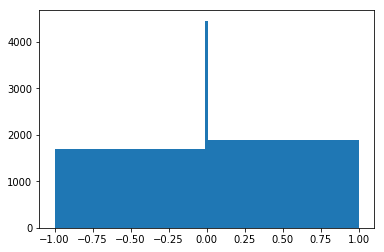

In [8]:
plt.hist(y_train, bins=[-1, -.01, .01, 1])

In [9]:
straight_indexes = [index for index, angle in enumerate(y_train) if angle > -.01 and angle < .01]
left_indexes = [index for index, angle in enumerate(y_train) if angle  < -.01]
right_indexes = [index for index, angle in enumerate(y_train) if angle > .01]

In [10]:
keep_num = min(len(straight_indexes), len(left_indexes), len(right_indexes))
keep_straight_indexes = np.random.choice(straight_indexes, keep_num)
keep_left_indexes = np.random.choice(left_indexes, keep_num)
keep_right_indexes = np.random.choice(right_indexes, keep_num)

## Setup and Train Network

In [11]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()

model.add(Convolution2D(96, 11, 11, subsample=(4,4), input_shape=(227, 227, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(256, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(384, 3, 3, border_mode='same'))
model.add(Activation('relu'))

model.add(Convolution2D(384, 3, 3, border_mode='same'))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((3,3)))

model.add(Flatten())
model.add(Dense(2048))
model.add(Dense(2048))
model.add(Dense(1))

Using TensorFlow backend.


In [ ]:
model.compile('adam', 'mse')
model.fit(X_train, y_train, nb_epoch=10, batch_size=128, validation_split=.2)

Train on 6428 samples, validate on 1608 samples
Epoch 1/10
6016/6428 [===========================>..] - ETA: 71s - loss: 4759609.9756   